In [36]:
%cd /jet/home/tvnguyen/JeansGNN/experiments
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch_geometric
import yaml

import jeans_gnn as jgnn

%matplotlib inline

plt.style.use('default.mplstyle')

/jet/home/tvnguyen/JeansGNN/experiments
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Read the training and validation datasets
dataset_path = 'data/example_data.hdf5'
node_features, graph_features, headers = jgnn.utils.dataset.read_graph_dataset(
    dataset_path, features_list=['pos', 'vel', 'labels'])
num_galaxies = headers['num_galaxies']

# print all headers of the training dataset
print('Headers:')
for k, v in headers.items():
    print('- {}: {}'.format(k, v))

Headers:
- all_features: ['pos' 'vel' 'vel_error' 'dm_alpha' 'dm_beta' 'dm_gamma' 'dm_r_dm'
 'dm_rho_0' 'stellar_r_star_r_dm' 'df_beta_0' 'df_r_a_r_star' 'num_stars'
 'dm_log_r_dm' 'dm_log_rho_0' 'stellar_log_r_star' 'df_log_r_a' 'labels'
 'original_idx']
- dataset_name: mini_gNFW_Plummer_OM_poisson100
- date: 2023-04-14 11:23:34
- df_type: QuasiSpherical
- dm_type: Spheroid
- error_los: 0
- flag: valid
- galaxy_name: mini_gNFW_Plummer_OM_poisson100
- graph_features: ['dm_alpha' 'dm_beta' 'dm_gamma' 'dm_r_dm' 'dm_rho_0'
 'stellar_r_star_r_dm' 'df_beta_0' 'df_r_a_r_star' 'num_stars'
 'dm_log_r_dm' 'dm_log_rho_0' 'stellar_log_r_star' 'df_log_r_a' 'labels'
 'original_idx']
- labels_order: ['dm_gamma' 'dm_log_r_dm' 'dm_log_rho_0' 'stellar_log_r_star' 'df_beta_0'
 'df_log_r_a']
- name: mini
- node_features: ['pos' 'vel' 'vel_error']
- num_galaxies: 100
- projection: 0
- stellar_type: Plummer
- train_frac: 0.9


In [3]:
# print the node features of the first 10 stars in the first galaxy
print("Node features:")
print("- pos: {}".format(node_features['pos'][0][:10]))
print("- vel: {}".format(node_features['vel'][0][:10]))

print("Graph features:")
print(headers['labels_order'])
print("- labels: {}".format(graph_features['labels'][0]))

Node features:
- pos: [[ 0.13504457  0.05950324]
 [-0.03729184 -0.151646  ]
 [-0.11927976 -0.11157647]
 [-0.03330625  0.06756137]
 [-0.00840738  0.03095477]
 [ 0.07772832 -0.04542598]
 [-0.06865919 -0.04856362]
 [ 0.02304553  0.0593613 ]
 [ 0.00202816  0.00174576]
 [ 0.10052064  0.04847484]]
- vel: [ 0.29824803 -0.04545442  0.21565156 -0.46745416 -0.20959343 -0.14228842
  0.66527882  0.53476856  0.24639451 -0.36439535]
Graph features:
['dm_gamma' 'dm_log_r_dm' 'dm_log_rho_0' 'stellar_log_r_star' 'df_beta_0'
 'df_log_r_a']
- labels: [ 1.79551026 -0.94841769  6.9007755  -1.12356432 -0.18195041 -0.90968556]


### First, we transform the labels into the log density profile

In [4]:
def log_gNFW(log_r, gamma, log_r_dm, log_rho_0):
    """ log of the gNFW density profile """
    # broadcast log_r to gamma, log_r_dm, log_rho_0
    # log_r = log_r[..., None]
    gamma = gamma[..., None]
    log_r_dm = log_r_dm[..., None]
    log_rho_0 = log_rho_0[..., None]

    # calculate the density profile
    x = np.exp(log_r - log_r_dm)  # r / r_dm
    return log_rho_0 - gamma * np.log(x) - (3 - gamma) * np.log(1 + x)

In [5]:
# Transform labels into density profile vs radius
gamma, log_r_dm, log_rho_0 = graph_features['labels'][:, :3].T

# Define bins
min_r_factor = 0.1
max_r_factor = 10.0
num_bins = 10

log_r = np.linspace(
    log_r_dm + np.log(min_r_factor), log_r_dm + np.log(max_r_factor),
    num_bins).T
log_rho = log_gNFW(log_r, gamma, log_r_dm, log_rho_0)

In [6]:
# Construct an object for data transformation
# graph construction based on torch_geometric.transforms.KNNGraph
# https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.KNNGraph
transform = jgnn.gnn.transforms.PhaseSpaceGraphProcessor(
    graph_name="KNNGraph",
    graph_params={
        "k": 5, 
        "force_undirected": True, 
        "loop": False
    },
    log_radius=True,
)

In [8]:
# Iterate over the training dataset
# and transform each graph to torch_geometric.data.Data
# https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data
data_list = []
for i in range(num_galaxies):
    data = transform(
        pos=node_features['pos'][i],
        vel=node_features['vel'][i],
        label=log_rho[i],
    )
    data_list.append(data)

# Construct a data loader using torch_geometric.loader.DataLoader:
# https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.DataLoader
# training dataset
train_loader = torch_geometric.loader.DataLoader(
    data_list[:90], batch_size=32, shuffle=True)
# validation dataset
val_loader = torch_geometric.loader.DataLoader(
    data_list[90:], batch_size=32, shuffle=True)

In [16]:
# In this example, we read the config file and convert it to a dictionary
with open('example_training.yaml', 'r') as f:
    config_dict = yaml.load(f, Loader=yaml.FullLoader)
model_params = config_dict['model']
model_params['out_channels'] = num_bins
optimizer_params = config_dict['optimizer']
scheduler_params = config_dict['scheduler']

# Construct a DensitySampler object
# Note that if resume=False, the DensitySampler will overwrite
# the existing run directory
inference_model = jgnn.im.gnn_im.GNNInferenceModel(
    run_name='example_recurrent_flow',
    model_params=model_params,
    optimizer_params=optimizer_params,
    scheduler_params=scheduler_params,
    resume=False
)

In [17]:
inference_model.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    max_epochs=100,
    save_top_k=1,
)

/ocean/projects/ast200012p/tvnguyen/miniconda3/envs/jeans-gnn-new/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /ocean/projects/ast200012p/tvnguyen/miniconda3/envs/ ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | GraphRegressor | 447 K 
-----------------------------------------
447 K     Trainable params
0         Non-trainable params
447 K     Total params
1.789     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/ocean/projects/ast200012p/tvnguyen/miniconda3/envs/jeans-gnn-new/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/ocean/projects/ast200012p/tvnguyen/miniconda3/envs/jeans-gnn-new/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/ocean/projects/ast200012p/tvnguyen/miniconda3/envs/jeans-gnn-new/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have man

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 29.130


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.244 >= min_delta = 0.0. New best score: 28.886


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.209 >= min_delta = 0.0. New best score: 28.677


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.207 >= min_delta = 0.0. New best score: 28.470


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.247 >= min_delta = 0.0. New best score: 28.223


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.300 >= min_delta = 0.0. New best score: 27.924


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.339 >= min_delta = 0.0. New best score: 27.585


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.461 >= min_delta = 0.0. New best score: 27.124


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.411 >= min_delta = 0.0. New best score: 26.712


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.734 >= min_delta = 0.0. New best score: 25.978


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.562 >= min_delta = 0.0. New best score: 25.416


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.581 >= min_delta = 0.0. New best score: 24.836


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.483 >= min_delta = 0.0. New best score: 24.353


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.268 >= min_delta = 0.0. New best score: 24.085


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.347 >= min_delta = 0.0. New best score: 23.738


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.350 >= min_delta = 0.0. New best score: 23.389


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.392 >= min_delta = 0.0. New best score: 22.996


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.420 >= min_delta = 0.0. New best score: 22.576


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.990 >= min_delta = 0.0. New best score: 21.585


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.092 >= min_delta = 0.0. New best score: 21.493


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.093 >= min_delta = 0.0. New best score: 21.400


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.782 >= min_delta = 0.0. New best score: 20.618


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.239 >= min_delta = 0.0. New best score: 20.379


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.440 >= min_delta = 0.0. New best score: 19.939


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.507 >= min_delta = 0.0. New best score: 19.432


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.467 >= min_delta = 0.0. New best score: 18.965


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.546 >= min_delta = 0.0. New best score: 18.418


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.914 >= min_delta = 0.0. New best score: 17.505


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.413 >= min_delta = 0.0. New best score: 16.091


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.771 >= min_delta = 0.0. New best score: 15.321


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.732 >= min_delta = 0.0. New best score: 14.589


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.230 >= min_delta = 0.0. New best score: 13.358


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.010 >= min_delta = 0.0. New best score: 12.349


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.159 >= min_delta = 0.0. New best score: 12.190


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.217 >= min_delta = 0.0. New best score: 11.973


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 11.921


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.246 >= min_delta = 0.0. New best score: 11.675


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.141 >= min_delta = 0.0. New best score: 11.534


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.408 >= min_delta = 0.0. New best score: 10.126


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.806 >= min_delta = 0.0. New best score: 9.321


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.521 >= min_delta = 0.0. New best score: 8.800


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.273 >= min_delta = 0.0. New best score: 8.527


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.650 >= min_delta = 0.0. New best score: 7.877


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.727 >= min_delta = 0.0. New best score: 7.150


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.473 >= min_delta = 0.0. New best score: 6.677


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.388 >= min_delta = 0.0. New best score: 5.288


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.073 >= min_delta = 0.0. New best score: 5.215


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.101 >= min_delta = 0.0. New best score: 5.114


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.546 >= min_delta = 0.0. New best score: 4.569


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.668 >= min_delta = 0.0. New best score: 1.901


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.464 >= min_delta = 0.0. New best score: 1.437


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.229 >= min_delta = 0.0. New best score: 1.207


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.198
`Trainer.fit` stopped: `max_epochs=100` reached.


In [51]:
num_samples = 10000  # number of posterior samples
posteriors, truths = inference_model.sample(
    data_loader=val_loader,
    num_samples=num_samples,
    return_labels=True,
)

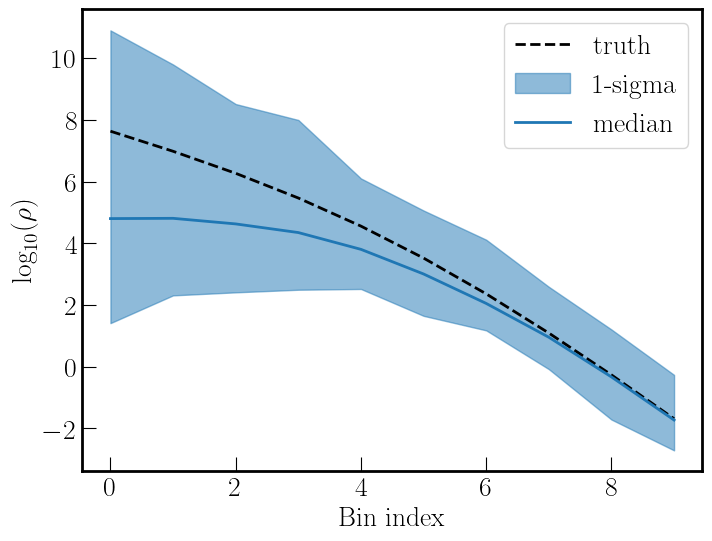

In [57]:
i = 4 # index of the galaxy

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# plot the truth density profile
ax.plot(np.arange(num_bins), truths[i], color='k', 
        lw=2, ls='--', label='truth')

# plot the posteriors as median and 1-sigma shaded region
post = posteriors[i]
post_q = np.quantile(post, [0.16, 0.5, 0.84], axis=0)
ax.fill_between(
    np.arange(num_bins), post_q[0], post_q[2],
    alpha=0.5, color='C0', label='1-sigma'
)
ax.plot(np.arange(num_bins), post_q[1], color='C0', 
        lw=2, ls='-', label='median')

# ax.set_xlabel(r'$\log_{10}(r)$')
ax.set_xlabel('Bin index')
ax.set_ylabel(r'$\log_{10}(\rho)$')
ax.legend()

plt.show()

## Graph regressor

In [58]:
from typing import Callable, Optional, Union

import torch
import torch_geometric
from torch_geometric.nn import ChebConv, GATConv, GCNConv

from jeans_gnn.gnn import base_modules, flows

In [60]:
class GraphRegressorTest(torch.nn.Module):
    def __init__(
            self, in_channels: int, out_channels: int,
            hidden_graph_channels: int = 1,
            num_graph_layers: int = 1,
            hidden_fc_channels: int = 1,
            num_fc_layers: int = 1,
            graph_layer_name: str = "ChebConv",
            graph_layer_params: Optional[dict] = None,
            activation: Union[str, torch.nn.Module, Callable] = "relu",
            activation_params: Optional[dict] = None,
            flow_params: dict = None
            ):
        super().__init__()

        if graph_layer_params is None:
            graph_layer_params = {}
        if activation_params is None:
            activation_params = {}

        self.graph_layer_name = graph_layer_name

        # Create the graph layers
        self.graph_layers = torch.nn.ModuleList()
        for i in range(num_graph_layers):
            n_in = in_channels if i == 0 else hidden_graph_channels
            n_out = hidden_graph_channels
            self.graph_layers.append(
                self._get_graph_layer(
                    n_in, n_out, graph_layer_name, graph_layer_params))

        # Create FC layers
        self.fc_layers = torch.nn.ModuleList()
        for i in range(num_fc_layers):
            n_in = hidden_fc_channels if i == 0 else hidden_fc_channels
            n_out = hidden_fc_channels
            self.fc_layers.append(torch.nn.Linear(n_in, n_out))

        # Create activation function
        if isinstance(activation, str):
            self.activation = getattr(torch.nn.functional, activation)
            self.activation_params = activation_params
        elif isinstance(activation, torch.nn.Module):
            self.activation = activation
            self.activation_params = {}
        elif isinstance(activation, Callable):
            self.activation = activation
            self.activation_params = activation_params
        else:
            raise ValueError("Invalid activation function")

        # Create MAF normalizing flow layers
        self.flows = build_maf(
            channels=out_channels, context_channels=hidden_fc_channels,
            **flow_params)

    def forward(self, x, edge_index, batch, edge_weight=None):
        # Apply graph and FC layers to extract features as the flows context
        # apply graph layers
        for layer in self.graph_layers:
            if self.HAS_EDGE_WEIGHT[self.graph_layer_name]:
                x = layer(x, edge_index, edge_weight=edge_weight)
            else:
                x = layer(x, edge_index)
            x = self.activation(x, **self.activation_params)
        # pool the features
        x = torch_geometric.nn.global_mean_pool(x, batch)

        # apply FC layers
        # do not apply activation function to the last layer
        for layer in self.fc_layers[:-1]:
            x = layer(x)
            x = self.activation(x, **self.activation_params)
        x = self.fc_layers[-1](x)

        return x

    def log_prob(self, batch, return_context=False):
        """ Calculate log-likelihood from batch """
        context = self.forward(
            batch.x, batch.edge_index, batch.batch, edge_weight=batch.edge_weight)
        log_prob = self.flows.log_prob(batch.y, context=context)

        if return_context:
            return log_prob, context
        return log_prob

    def sample(self, batch, num_samples, return_context=False):
        """ Sample from batch """
        context = self.forward(
            batch.x, batch.edge_index, batch.batch, edge_weight=batch.edge_weight)

        y = self.flows.sample(num_samples, context=context)

        if return_context:
            return y, context
        return y

    def log_prob_from_context(self, x, context):
        """ Return MAF log-likelihood P(x | context)"""
        return self.flows.log_prob(x, context=context)

    def sample_from_context(self, num_samples, context):
        """ Sample P(x | context) """
        return self.flows.sample(num_samples, context=context)

    def _get_graph_layer(
            self, in_dim, out_dim, graph_layer_name, graph_layer_params):
        """ Return a graph layer

        Parameters
        ----------
        in_dim: int
            Input dimension
        out_dim: int
            Output dimension
        graph_layer_name: str
            Name of the graph layer
        graph_layer_params: dict
            Parameters of the graph layer

        Returns
        -------
        graph_layer: torch.nn.Module
        """
        if graph_layer_name not in self.GRAPH_LAYERS:
            raise ValueError(f"Graph layer {graph_layer_name} not implemented")
        return self.GRAPH_LAYERS[graph_layer_name](
            in_dim, out_dim, **graph_layer_params)

class GraphRegressorModule(BaseFlowModule):
    """ Graph Regressor module """
    def __init__(
            self, model_hparams: Optional[dict] = None,
            optimizer_hparams: Optional[dict] = None,
            scheduler_hparams: Optional[dict] = None,
        ) -> None:
        super().__init__(
            GraphRegressor, model_hparams, optimizer_hparams, scheduler_hparams)


NameError: name 'BaseFlowModule' is not defined